In [127]:
# setup
options(warn=-1)
library(reshape2)
library(magrittr)
library(dplyr)
library(ggplot2)
library(viridis)
library(stringr)

DATA.DIR = '../data/'

tellme = function(x){
    read.csv(paste0(DATA.DIR,'/police_stop_data_dictionary.csv')) %>%
        filter(Column.Name==x) %>%
        select(Description) %>%
        return
}

app.key.list = function(n){
    key = paste0('rpt',as.character(n))
    data %>% select(starts_with(key)) %>% names %>% return
}
?options

## Introduction
On May 1, 2019 the Boulder Police Department (BDP) [released a (cleaned and processed) dataset](https://www.denverpost.com/2019/05/01/people-of-color-arrests-boulder-police-stop/) containing data on all *discretionary* stops made by Boulder police in 2018. Discretionary stops make up only a fraction of Boulder police activity, with the vast majority of police interactions being *non-discretionary*, eg. where an officer was dispatched based on a 911 call or following a warrant. Approximately 66,400 police interactions are non-discretionary (per an in-person workshop on the data organized by the City of Boulder on May 6, 2019), whereas 8,209 are discretionary (per the released data). 

The data were compiled on the recommendation of the consulting firm Hillard Heintz, who in 2016 were hired to perform an internal study of arrest and citation activity within BPD. In an analysis of this 2018 data, Hillard Heintz [concluded](https://www.dailycamera.com/2019/04/30/data-people-of-color-more-likely-to-be-arrested-after-boulder-police-stops/) that "black people are twice as likely as white people to be stopped at an officer’s discretion, and once stopped, they are twice as likely to be arrested". In addition to these results, the City of Boulder released an [official report](https://bouldercolorado.gov/police/stop-data-information) which contained a few high-level takeaways:
1. The report represents only a single year of data and "cannot yet be put into context" (ie. trending up or down)
2. Small data sizes mean that small changes in stop or citation number may have meaningful effects in data trends
3. Laws and policies regulating discretionary action can have "significant positive effects", but will require coordinated action
4. Racial differences in stop rates differ by base population (eg. residents vs nonresidents) 

In our analysis of the data we generally found these summaries to be true, but conservative descriptors of what the data shows. Agreeing with the official analysis of the dataset we find strong evidence that racial bias is occurring across all types of discretionary stop by BPD. Regardless of trend or context, in 2018 it was a real, urgent, and sizeable problem. If BPD were to stop black individuals at the same rate as white individuals (relative to the base population estimates given in the report) it would have constituted 220 fewer stops in 2018.

Breaking down the stop data by "stop reason" highlights some of the reasons why this bias occurs in the top-level. Black individuals are stopped more frequently than white individuals in every type of stop listed except for "welfare checks", where BPD is more likely to stop white individuals.  Furthermore, black individuals who are searched for contraband are less likely to have it than their white counterparts. These conclusions clearly indicate that, on aggregate, BPD are unreasonably disposed to stop black individuals. Similar results also typically hold for white hispanic individuals, although base demographic information was not provided for this group and so the results are more limited.

### Front Matter
These stops, to us, are a clear injustice that needs to be redressed immediately. While we're glad that BPD have released this data and therby taken a real step towards justice and transparency, this is really only one change out of many that need to happen today, is meaningless if it doesn't lead to serious changes in their day-to-day operations and procedures.

Before going any further it's important to read Candice Lanius' excellent essay ["Your Demand for Statistical Proof is Racist"](https://thesocietypages.org/cyborgology/2015/01/12/fact-check-your-demand-for-statistical-proof-is-racist/). To quote:

>Perhaps statistics should be considered a technology of mistrust—statistics are used when personal experience is in doubt because the analyst has no intimate knowledge of it. Statistics are consistently used as a technology of the educated elite to discuss the lower classes and subaltern populations, those individuals that are considered unknowable and untrustworthy of delivering their own accounts of their daily life. A demand for statistical proof is blatant distrust of someone’s lived experience. The very demand for statistical proof is otherizing because it defines the subject as an outsider, not worthy of the benefit of the doubt.

In short: nothing here is new, and if this analysis is the thing that changes your opinions on racial police activity in America then you're probably (a) not paying attention and (b) disregarding the lived experiences of your fellow Americans. Black lives matter.

### About the Data
The original data is broken into two files: `police_stop_data_main_2018.csv` and `police_stop_data_results_2018.csv`. The first dataset contains a row for every individual discretionary stop made by Boulder PD. Let's see what columns the data includes:

In [6]:
'police_stop_data_main_2018.csv' %>% paste0(DATA.DIR,.) %>% read.csv %>% names %>% print

 [1] "stopdate"      "stoptime"      "streetnbr"     "streetdir"    
 [5] "street"        "Min"           "sex"           "race"         
 [9] "ethnic"        "Year.of.birth" "enfaction"     "rpmainid"     


We see columns for stop date, time, and duration (in minutes), as well as for race, ethnicity, and sex of the stopped individual **as percieved by the reporting officer**. We also have columns `enfaction`, which indicates if the stopped individual was a resident of Boulder or not, and an `rpmainid`, which links each row to data in the second dataset.

The structure of `police_stop_data_results_2018.csv` is slightly more complex. This file contains information on the stops listed in the `main` dataset, as well as any potential outcomes of each. Let's see what columns it has:

In [7]:
'police_stop_data_results_2018.csv' %>% paste0(DATA.DIR,.) %>% read.csv %>% names %>% print

[1] "appkey"   "appid"    "itemcode" "itemdesc" "addtime" 


The `appid` column is used to link rows in `results` to rows in `main` (through the `rpmainid` column in `main`). A big difference here is that each value of `rpmainid` appears only once in `main`, whereas a single `appid` might be listed in multiple rows in `results`, corresponding to multiple outcomes of the same stop. The `appkey` column contains one of seven different values, 'RPT1' through 'RPT7', which indicate what kind of information is contained in the row:

| Appkey | Data              |
|--------|-------------------|
| RPT1   | Stop type         |
| RPT2   | Stop reason       |
| RPT3   | Search conducted  |
| RPT4   |  Search authority |
| RPT5   |  Contraband found |
| RPT6   | Result of stop    |
| RPT7   |  Charge issued    |


The corresponding info is then stored in `itemdesc`. Each pair of `appid` and `appkey` might be listed in multiple rows, eg. if there's more than one reason for the stop. This is not a very convenient data stucture. It would be far better if all of the information was present in a single dataset, and if each row corresponded to exactly one stop (ie. if the data was "tidy"). Fortunately my friend [Sam](https://github.com/samzhang111) has gone ahead and [tidied]() the data. This basically swings the each `appkey`/`infodesc` pair out into its own column, with a 1 in that colum indicating that the `appkey` for that stop had the `infodesc` value. For example, if in the un-tidied data one row has an `appkey` of "rpt1" and an `infodesc` of "pedestrian" that gets converted into a "1" under the column `rpt1.pedestrian`. Let's see what this looks like...

In [8]:
dat = read.csv(paste0(DATA.DIR,'tidy.csv')) %>% set_colnames(tolower(names(.)))
# do a little cleaning data cleaning and combine columns
dat %<>% mutate(raceethn=ifelse(ethnic=='H',race%>%paste0('H'), race%>%as.character))
dat %<>% mutate(rpt2.traffic.speeding= rpt2.speeding | rpt2.traffic.speeding ) %>% select(-rpt2.speeding)
dat %<>% mutate(rpt2.traffic.right.of.way.violation= rpt2.right.of.way.violation | rpt2.traffic.right.of.way.violation ) %>% select(-rpt2.right.of.way.violation)
dat$traffic.stop = dat %>% select(starts_with('rpt2.traffic')) %>% apply(1,any)
dat %>% names %>% print

 [1] "stopdate"                            "stoptime"                           
 [3] "streetnbr"                           "streetdir"                          
 [5] "street"                              "min"                                
 [7] "sex"                                 "race"                               
 [9] "ethnic"                              "year.of.birth"                      
[11] "enfaction"                           "rpmainid"                           
[13] "raceethn"                            "rpt1.pedestrian"                    
[15] "rpt1.vehicle"                        "rpt2.disturbance"                   
[17] "rpt2.equipment.violation"            "rpt2.municipal.violation"           
[19] "rpt2.noise.violation"                "rpt2.state.violation"               
[21] "rpt2.suspicious"                     "rpt2.traffic.parking.violation"     
[23] "rpt2.traffic.reckless.careless"      "rpt2.traffic.reddi.observed.pc"     
[25] "rpt2.traffic.right.of.

This clearly produces a lot of columns (one column for every possible pair of `appkey` and `infodesc`). Nevertheless this format will be very convenient going forward. Let's see the first few rows just of the "rpt2" information (which corresponds to the stop reason) to get a feel for what the tidying process produced.

In [9]:
dat %>% select(starts_with('rpt2')) %>% head

rpt2.disturbance,rpt2.equipment.violation,rpt2.municipal.violation,rpt2.noise.violation,rpt2.state.violation,rpt2.suspicious,rpt2.traffic.parking.violation,rpt2.traffic.reckless.careless,rpt2.traffic.reddi.observed.pc,rpt2.traffic.right.of.way.violation,rpt2.traffic.speeding,rpt2.welfare.check
0,0,0,0,0,0,0,0,0,FALSE,TRUE,0
0,0,0,0,0,0,0,1,0,FALSE,FALSE,0
0,0,1,0,0,0,0,0,0,FALSE,FALSE,0
0,0,1,0,0,0,0,0,0,FALSE,FALSE,0
0,0,1,0,0,0,0,0,0,FALSE,FALSE,0
0,0,1,0,0,0,0,0,0,FALSE,FALSE,0


A few of the columns are "TRUE/FALSE" coded instead of "1/0" coded, but this makes no difference. R treats them as the same thing:

In [6]:
TRUE == 1
FALSE == 0
TRUE + TRUE
1 + FALSE

[1] TRUE

[1] TRUE

[1] 2

[1] 1

### Analysis Methodology
In this analysis we're going to want to estimate the probability that certain things occur, eg. "what's the probability that a stop occurred because someone was 'suspicious'?". We estimate these probabilities using the Bayesian methodology. The basic approach here is to find a probability distribution *over probabilities*. That is, given some set binary yes/no observations, we're going to construct what's called the "posterior distribution" over possible values of the probability of a "yes". 

The practical upshot of this is that, for any given "Event" (eg. someone getting searched) we're going to get a boxplot over the probability of that event occuring. The median of the boxplot is going to be our "point estimate" of that probability, and the quantiles of the boxplot are going to give us our error bars. When those boxplots exhibit separation across races, it's indicative of racial differences in the event probabilities.

The theory underlying all of this is (interesting, but) complicated and we're not going to go into it here. The advantage is that it's a lot more flexible and intuitive (after some reading) than the usual "p-value statistics" you may have learned in Stats 101.The qualitative conclusions drawn using this approach should be broadly the same (although we leave the verification of that fact as an exercise to the reader).

The following block of code defines the functions underlying this methodology, and presents a simple example of what the output will look like. 

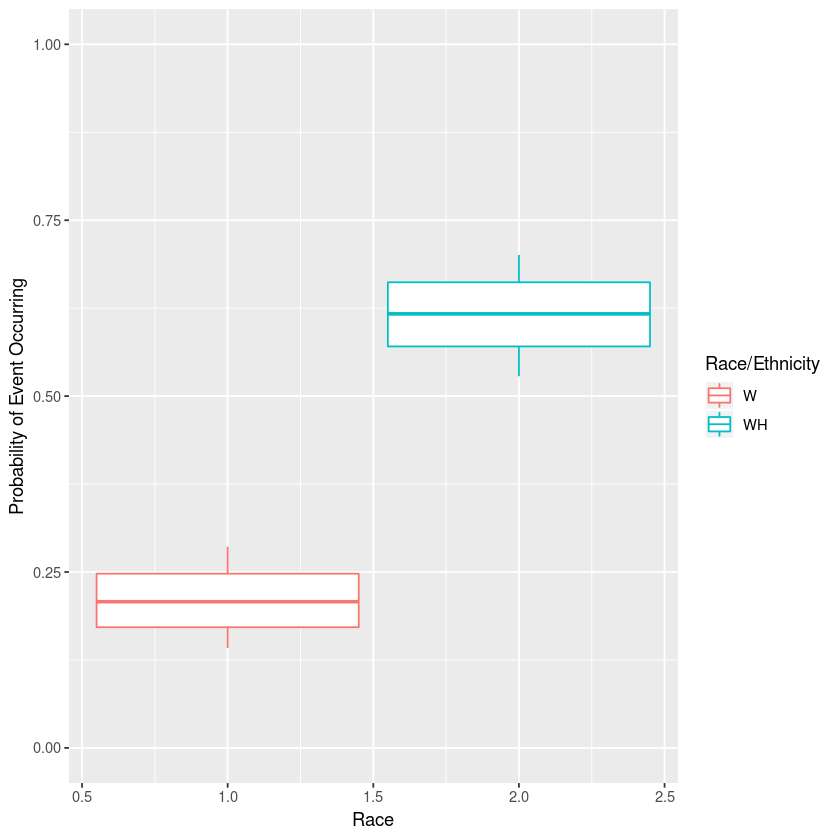

In [121]:
# DEFINE HELPER FUNCTIONS 
    # posterior quantiles given binomial likelihood and beta prior                              
binom.posterior = function(q, outcome_vec, pr.alpha=1, pr.beta=1){
    q %>% qbeta(pr.alpha + sum(outcome_vec), pr.beta + length(outcome_vec) - sum(outcome_vec)) %>%
        return
}
    # wrapper function to create boxplots
plot.posterior = function(post,race.cutoff=100){    
    q = c(.1,.25,.50,.75,.9)
    races = dat %>% group_by(raceethn) %>% filter(n()>race.cutoff) %>% as.data.frame %>%
            select(raceethn) %>%
            unique %>% unlist %>% as.character
    
    not.all.zero = function(x){!all(x==0)}
    plot.df = sapply(races, function(r){q %>% post(r)}) %>% as.data.frame %>%
    set_colnames(races) %>% select_if(not.all.zero)

    plot.df$q = q
    plot.df %<>%  melt('q') %>% set_colnames(c('q','race','quantiles')) %>% dcast(race ~ q ) 
    plot.df %<>% set_colnames(c('race','y0','y25','y50','y75','y100'))
    plot.df$x = as.numeric(plot.df$race)
    p = ggplot( plot.df, aes(x=x,group=as.factor(race), color=as.factor(race)) ) +
        geom_boxplot( aes(ymin = y0, 
                          lower = y25, 
                          middle = y50, 
                          upper = y75, 
                          ymax = y100), stat = "identity") +
        xlab('Race') + ylab('Posterior Density') + labs(color='Race/Ethnicity')
    p %>% return
}

# a quick example of the output of this methodology

n = 50
p.w = .2
p.wh = p.w + .5
outcome.w = rbinom(n,1,p.w)
outcome.wh = rbinom(n,1,p.wh)

test.post = function(q,r) {
    if (r=='W'){
        binom.posterior(q,outcome.w) %>% return
        }
    
    else if (r=='WH'){
        binom.posterior(q,outcome.wh) %>% return
        #0 %>% return
    }
    
    else{
        0 %>% return
    }
        

}

suppressMessages(print(plot.posterior(test.post, race.cutoff=100) + ylim(c(0,1)) + ylab('Probability of Event Occurring')))

In the above example we draw 50 yes/no samples of an event that occurs "yes" with 20% of the time for white ("W") individuals  and 70% of the time for white-hispanic ("WH") individuals. Based on these "observations" we then plot boxplots over the probabilities of these events occuring for each of these two races/ethnicities. We see that the 50% discrepancy in the stop rates is approximately reflected in the separation of the boxplots.

## Data Analysis
### Assessing Top-Level Bias
A key challenge in assessing bias in top-level stop rates is the so-called "denominator problem": if X% of individuals stopped were of race R we typically want to know whether this number reflects the underlying demographics of the policed population. If race R is Y% of the population and Y << X then this indicates that race R is being over-policed, or vice versa. The problem is that, for a city like Boulder, the total policed population includes not only the census population (ie. "residents"), but also commuters, students, and unhoused folks. The City of Boulder did a lot of work estimating demographic information about the policed, and their findings can be found in their [2018 Annual Report](https://bouldercolorado.gov/police/stop-data-information). For our purposes we're just going to pull their population totals and demographic breakdown information and enter it manually. We'll then repeat and confirm their conclusions, that black individuals are stopped more frequently than white indiviuals. Only race was included in the demographic information, not ethnicity, so we have no baselines for white or black hispanic individuals.

In [101]:
pop.totals = c(106271,34510,21001,1960)
white.percent = c(.879,.659,.687,.631)
black.percent = c(.011,.025,.027,.074)
asian.percent = c(.053,.078,.039,.006)
indig.percent = c(.003,.016,.009,.028)

demography.df = data.frame(race=c('white'))

race.totals = c(sum(white.percent*pop.totals),
                sum(indig.percent*pop.totals),
                sum(black.percent*pop.totals),
                sum(asian.percent*pop.totals)
    ) %>% rev
race.percent = round(race.totals/sum(race.totals),2)

To measure top level stop rates by race we can simply count the number of occurences of each race in the `race` column of the tidied data (recall that each row of the tidied data corresponds to a single unique stop). Note that a single individual may have been stopped multiple time, and in that case would appear as two or more rows in the tidied data.

In [102]:
stop.breakdown = dat %>% filter(race=='W'|race=='B'|race=='A'|race=='I') %>%
group_by(race) %>% 
summarize(Stops=n(),
          Percent=round(n()/nrow(dat),2)) %>%
mutate('Pop Percent'=race.percent, 
       'Pop Total'=race.totals)
stop.breakdown

race,Stops,Percent,Pop Percent,Pop Total
A,310,0.04,0.06,9154.942
B,353,0.04,0.02,2743.798
I,36,0.00,0.01,1114.862
W,7425,0.90,0.91,131818.746


As indicated in the Annual Report, there does appear to be some mismatch between stop rates and demographic representation. But just from this table it's not clear if these differences are meaningful, or if they just represent noise. We can use the Bayesian approach to address this. By plotting the posterior density over the probability of being in the stopped by race (using the demographic baselines provided) we can get a sense of whether these differences are meaningful. 

Using quantiles as value column: use value.var to override.


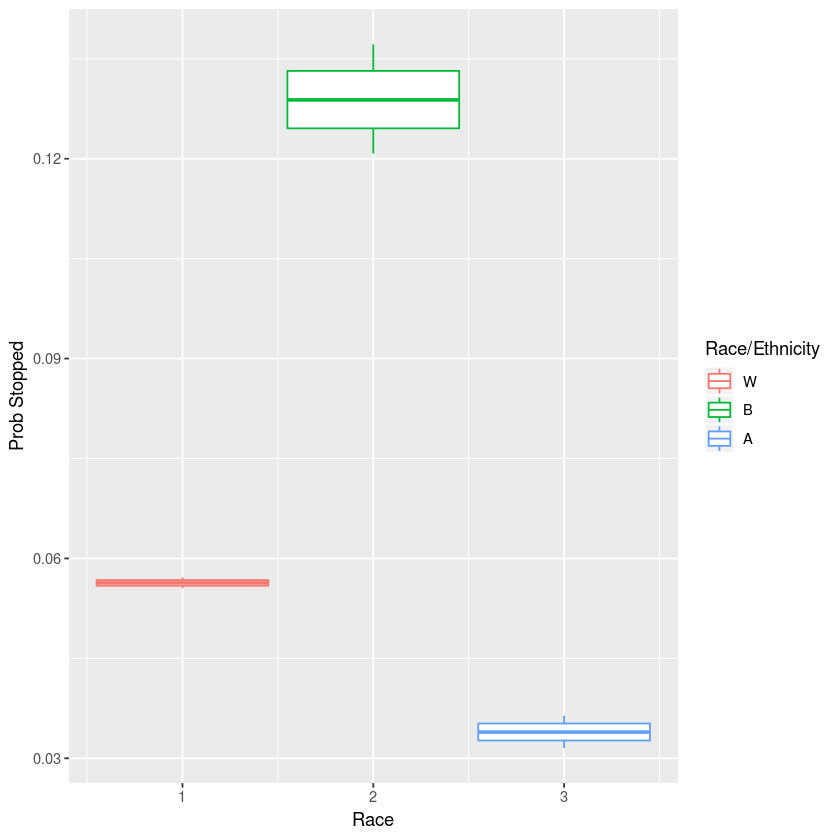

In [129]:
top.stop.posterior = function(q,r){
    if (r == 'WH') { return(0.0) }
    
    n = stop.breakdown %>% filter(race==r) %>% 
    select('Pop Total') %>% unlist %>% as.numeric
    
    stopped = stop.breakdown %>% filter(race==r) %>% 
    select(Stops) %>% unlist %>% as.numeric
    
    a = 1 + stopped
    b = 1 + n - stopped

    return( qbeta(q,a,b) )    

}
?geom_boxplot
plot.posterior(top.stop.posterior,race.cutoff=100) + ylab('Prob Stopped')

Since the posterior densities exhibit substantial amounts of separation it's pretty clear that there are *big* racial differences between the probabilities of experiencing a discretionary stop (as expected). Asian individuals seem to have similar, low probability of being stopped, relative to white individuals. On the other hand, black individuals are *substantially* more likely to be included in this data, and there appears to be no overlap with the other posterior densities. This is pretty clear evidence that race has some kind of effect on police stop rates. Let's dig in on why this might be the case.

### Most racialized search reason?
What accounts for this difference in stop rates? Every stop lists a reason for why the officier initiated the stop. Some of the given reasons seem especially likely to be exhibit differences across races (eg. one stop reason is that the officer was "suspicious"). Given this, we might ask "what stop reason shows the most (and *most significant*) variability across races?" To answer this question we can perform some Bayesian hypothesis testing. For a given stop reason, we'll compare the hypothesis that all races have the **same** probability of being stopped with this reason ($H_0$, "no bias") to the hypothesis that all races have **different** probabilities of being stopped for this reason ($H_1$, "bias"). To perform this test we'll use the Bayes factor (BF), which is defined as $\frac{\text{Pr}[H_1|D]}{\text{Pr}[H_0|D]}$, where $D$ is the collected data. When the BF >> 1 then we conclude that the data strongly favors $H_1$, which in our case indicates unequal treatment across races. Since BFs tend have an extreme order of magnitude, we'll instead work on the log scale to prevent numerical problems.

However BF alone may not capture precisely what we want. The BF may indicate that a racial bias clearly exists, but that size of that bias may be very small. Let's therefore define a loose "racialization" metric as the log BF (scaled by the maximum log BF across all stop reasons) multiplied by the median difference between Black and White stop rates for that reason (in units of "extra individuals stopped", normalized again by the max value). When this index is positive and large it indicates a potential source of the difference in top-level stop rates.

In [105]:
ln.beta.approx = function(a,b){
    ret = log(beta(a,b))
    if (abs(ret)<Inf){
        return(ret)
    }
    
    ret = .5*log(2*pi) + (a-.5)*log(a) + (b-.5)*log(b) - (a+b-.5)*log(a+b)
    
}

ln.binom.approx = function(n,k){
    ret = log(choose(n,k))
    
    if (ret<Inf){ return(ret) }
    
    ret = .5*log(n) - .5*log(2*pi*k*(n-k)) + n*log(n) - k*log(k) - (n-k)*log(n-k)
    return(ret)
}

bayes.factor.by.stop.reason = function(itemdesc, res=NULL, race.cutoff=200){ 
    races = dat %>% group_by(raceethn) %>% filter(n()>race.cutoff) %>% as.data.frame %>%
    select(raceethn) %>% unique %>% unlist
    
    races = c('B','W')

    numer.terms = c()
    for (i in 1:length(races)){
        race = races[i]
        
        if (is.null(res)){
            outcome = dat[dat$raceethn==race,] %>% select(itemdesc) %>% unlist 
            }
        
        else {
            outcome = dat[dat$raceethn==race,] %>% filter(enfaction==res) %>% select(itemdesc) %>% unlist 
        }
        
        n = stop.breakdown[stop.breakdown$race==race, c('Pop Total')] %>% unlist
        k = sum(outcome)
        
        a = 1 + k
        b = 1 + n - k

        numer.terms %<>% append(ln.beta.approx(a,b) + ln.binom.approx(n,k))
    }
    mod1.ln.prD = sum(numer.terms)
    
    if (is.null(res)){
        outcome = dat %>% filter(raceethn=='W'|raceethn=='B') %>% select(itemdesc) %>% unlist
        }
    
    else{
        outcome = dat %>% filter(raceethn=='W'|raceethn=='B') %>% filter(enfaction==res) %>% select(itemdesc) %>% unlist
    }
    
    n = stop.breakdown[, c('Pop Total')] %>% sum
    k = sum(outcome)
    
    a = 1 + n
    b = 1 + n - k
    mod2.ln.prD = ln.beta.approx(a,b) + ln.binom.approx(n,k)
    
    return(mod1.ln.prD - mod2.ln.prD)
    
}

bw.bias.by.stop.reason = function(itemdesc, res=NULL){ 
    races = c('B','W')
    meds = c()
    sizes = c()
    
    for (i in 1:length(races)){
        race = races[i]
        
        if (is.null(res)){
            outcome = dat[dat$raceethn==race,] %>% select(itemdesc) %>% unlist 
            }
        
        else {
            outcome = dat[dat$raceethn==race,] %>% filter(enfaction==res) %>% select(itemdesc) %>% unlist 
        }
        
        n = stop.breakdown[stop.breakdown$race==race, c('Pop Total')] %>% unlist
        k = sum(outcome)
        
        a = 1 + k
        b = 1 + n - k
        
        meds %<>% append(qbeta(.5,a,b))
        sizes %<>% append(n)
        
    }
    return((meds[1]-meds[2])*sizes[1])
    
}


stop.reasons = dat %>% select(starts_with('rpt2')) %>% names

racialized.df = data.frame('reason'=(stop.reasons %>%str_remove('rpt2.')),
                           'ln.bayes.factor'=sapply(stop.reasons,bayes.factor.by.stop.reason),
                           'bw.bias'=sapply(stop.reasons,bw.bias.by.stop.reason)
) %>% mutate( racialization=(ln.bayes.factor/max(ln.bayes.factor))*(bw.bias/max(bw.bias)) ) %>% arrange(-racialization)

racialized.df.res = data.frame('reason'=(stop.reasons %>%str_remove('rpt2.')),
                               'ln.bayes.factor'=sapply(stop.reasons, function(x) {bayes.factor.by.stop.reason(x,res='Y')}),
                               'bw.bias'=sapply(stop.reasons, function(x) {bw.bias.by.stop.reason(x,res='Y')})
) %>% mutate( racialization=(ln.bayes.factor/max(ln.bayes.factor))*(bw.bias/max(bw.bias)) ) %>% arrange(-racialization)

racialized.df.nonres = data.frame('reason'=(stop.reasons %>%str_remove('rpt2.')),
                               'ln.bayes.factor'=sapply(stop.reasons, function(x) {bayes.factor.by.stop.reason(x,res='N')}),
                               'bw.bias'=sapply(stop.reasons, function(x) {bw.bias.by.stop.reason(x,res='N')})
) %>% mutate( racialization=(ln.bayes.factor/max(ln.bayes.factor))*(bw.bias/max(bw.bias)) ) %>% arrange(-racialization)

print('Racialization for resident stops')
print(racialized.df.res)
print('Racialization for non-resident stops')
print(racialized.df.nonres)
print('Extra Stops:')
sum(racialized.df$bw.bias)

[1] "Racialization for resident stops"
                           reason ln.bayes.factor    bw.bias racialization
1             municipal.violation        196451.3 13.6309960    0.97884150
2             equipment.violation        197514.4  8.9655858    0.64730264
3                traffic.speeding        193359.1  7.6798996    0.54281275
4       traffic.reckless.careless        198742.6  6.6324664    0.48183224
5  traffic.right.of.way.violation        198347.0  6.4662227    0.46882019
6                      suspicious        200133.4  5.3619983    0.39226190
7                 state.violation        200001.5  2.9895774    0.21856119
8       traffic.parking.violation        200697.7  2.5755342    0.18894688
9                 noise.violation        200697.7  1.5595054    0.11440876
10                  welfare.check        200510.2  1.1640818    0.08531982
11      traffic.reddi.observed.pc        200243.2  0.5396494    0.03950022
12                    disturbance        200605.9  0.3666836 

[1] 221.7914

Almost every stop reason in the dataset exhibits a large and significant anti-black bias. The `bw.bias` column above lists the discrepancy in stop rates (in units of "stopped individuals"). The bias is largest for non-resident stops, although the leading stop types appear to be similar for both categories (ie. municipal violations and speeding or other traffic violations). The relatively high bias in the "suspicious" stop reason is also telling. That black individuals viewed with elevated suspicion is further underlined by the fact that the only time BPD are more likely to stop a white individual is when performing a non-resident "welfare check". In total, over 220 "extra" black individuals are policed per year (ie. 220 folks are subject to discretionary stops who would not have been if black individuals were policed at the same rate as white individuals). We will now look at some of the discrepancies in stop outcome.

### Given someone is searched, what's the probability that they have contraband?
A common counterpoint to analyses like the above is that racial differences in stop rates may reflect racial differences in the underlying crime rates, rather than racial bias per se. One way that we can test whether this claim is consistent with the data is by performing what's called an outcome test. This idea originated in the economics literature to test whether loan officers were discriminating against black applicants. The idea (in its original use) was to look at whether blacks individuals who *did* recieve home loans defaulted at a lower rate than their white counterparts. If the data showed that this was the case (and it did), then it indicated that the loan officers were holding black applicants to a higher standard than white applicants. We can apply a similar logic here, and look at the rates at which police searches turn up contraband. If black individuals who are searched are *less* likely to have contraband than white individuals who are searched, then it suggests that police are searching black individuals with a lower threshold of evidence, ie. that racial animus is probably a factor in their decision to search. This test [is not perfect](https://openpolicing.stanford.edu/findings/), but the case where this test fails to estimate difference in evidence thresholds is when white individuals are more likely criminal than black individuals. In this case we will still have ruled out that heightened policing of black individuals reflects criminal trends. Let's plot the posterior density over the probability that, given someone is searched, the search turns up contraband:

[1] "\"Unnecessary\" searches of black individuals:"
[1] 56.94529


Using quantiles as value column: use value.var to override.


Using quantiles as value column: use value.var to override.


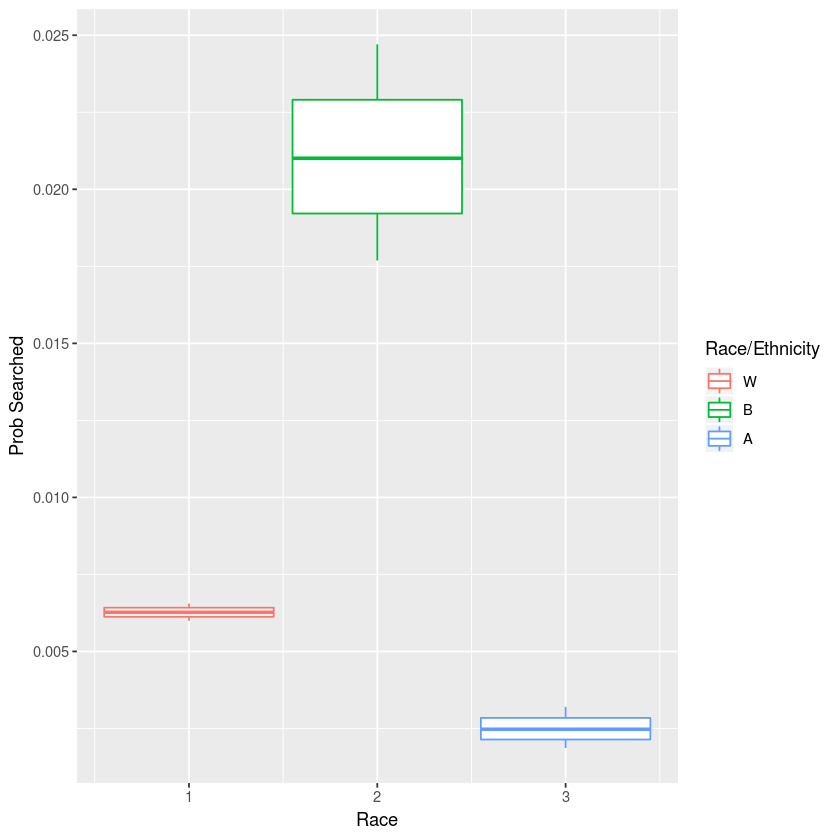

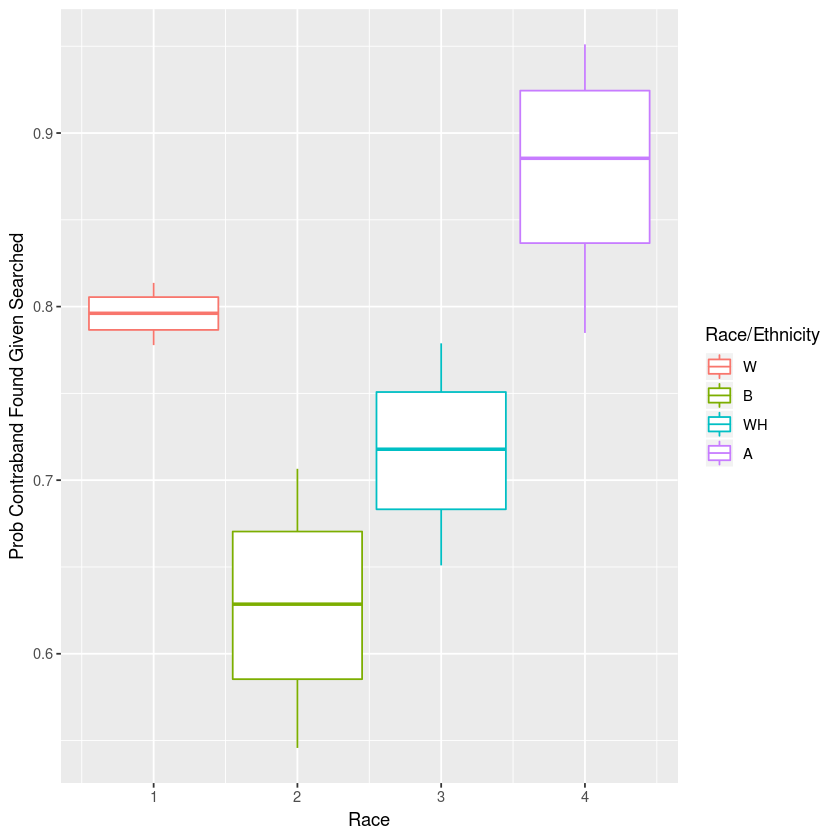

In [153]:
prob.searched.by.race = function(q,r){
        if (r == 'WH') { return(0.0) }
    
        n = stop.breakdown %>% filter(race==r) %>% 
        select('Pop Total') %>% unlist %>% as.numeric
    
        stopped = dat %>% mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>% 
                filter(raceethn==r) %>% select(rpt3.search) %>% unlist %>% sum
    
        a = 1 + stopped
        b = 1 + n - stopped

        return( qbeta(q,a,b) )    
}

prob.cont.given.searched = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt3.search==1) %>%
                                            select(rpt5.nothing.seized) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }

prob.cont.given.searched.resident = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt3.search==1 & enfaction=='Y') %>%
                                            select(rpt5.nothing.seized) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }

prob.cont.given.searched.nonresident = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt3.search==1 & enfaction=='N') %>%
                                            select(rpt5.nothing.seized) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }

prob.cont.given.searched.consent = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt3.search==1 & rpt4.consent==1) %>%
                                            select(rpt5.nothing.seized) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }

prob.cont.given.searched.noconsent = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt3.search==1 & rpt4.consent==0) %>%
                                            select(rpt5.nothing.seized) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }


n.w = dat %>% mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>% filter(raceethn=='W' & rpt3.search==1) %>% nrow
p.w = dat %>% mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>% filter(raceethn=='W' & rpt3.search==1 & rpt5.nothing.seized==0) %>% nrow

n.b = dat %>% mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>% filter(raceethn=='B' & rpt3.search==1) %>% nrow
k.b = dat %>% mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>% filter(raceethn=='B' & rpt3.search==1& rpt5.nothing.seized==0) %>% nrow
print('"Unnecessary" searches of black individuals:')
print(n.b - k.b/p.w)

plot.posterior(prob.searched.by.race) + ylab('Prob Searched')
plot.posterior(prob.cont.given.searched) + ylab('Prob Contraband Found Given Searched')


Black individuals are the most likely to be searched, but the least likely to carry contraband (among those searched). The discrepancy in outcome holds for both residents and non-residents, and for consent and non-consent searches. Assuming that white individuals are not more likely to carry contraband than black individuals, the different standard of evidence BPD appears to require to conduct a searched resulted in around 56 "unnecessary" searches of black individuals. In other words: to get equal rates of contraband discovery between black and white individuals, BPD would need to have searched 56 fewer innocent, black individuals.

### Given someone is speeding, what's the probability they get cited?
According to our analysis, one of the most "racialized" stop reasons was speeding stops. We can apply an outcome test here as well, to asses whether this difference reflects real differences in perpetration rates. We find, despite being cited for speeding less, black drivers were arrested more. Furthermore, of those arrested during a speeding stop, black drivers were ultimately charged *substantially less*.

An outcome test does struggle here a little, because the outcome (the issuance of a speeding citation) is at the stopping officer's discretion. If black drivers are cited less it *could* (technically) be the case that Boulder PD are just more lenient towards black drivers (which seems unlikely, given the discrepancy in contraband rates, a mountain of sociological research, the history of policing in America, and the lived experience of black and brown Americans). Indeed we do see that black drivers are more likely to recieve a warning than other drivers. My best-gues explanation here is that black drivers are being stopped at lower driving speeds which don't justify a ciation (maybe 1-10 MPH over the limit). A more complete dataset could clarify this ambiguity: if we had access to the recorded driving speed of the stopped drivers we could apply the test to those values, rather than just the binary cited/not cited outcome.

Using quantiles as value column: use value.var to override.


Using quantiles as value column: use value.var to override.


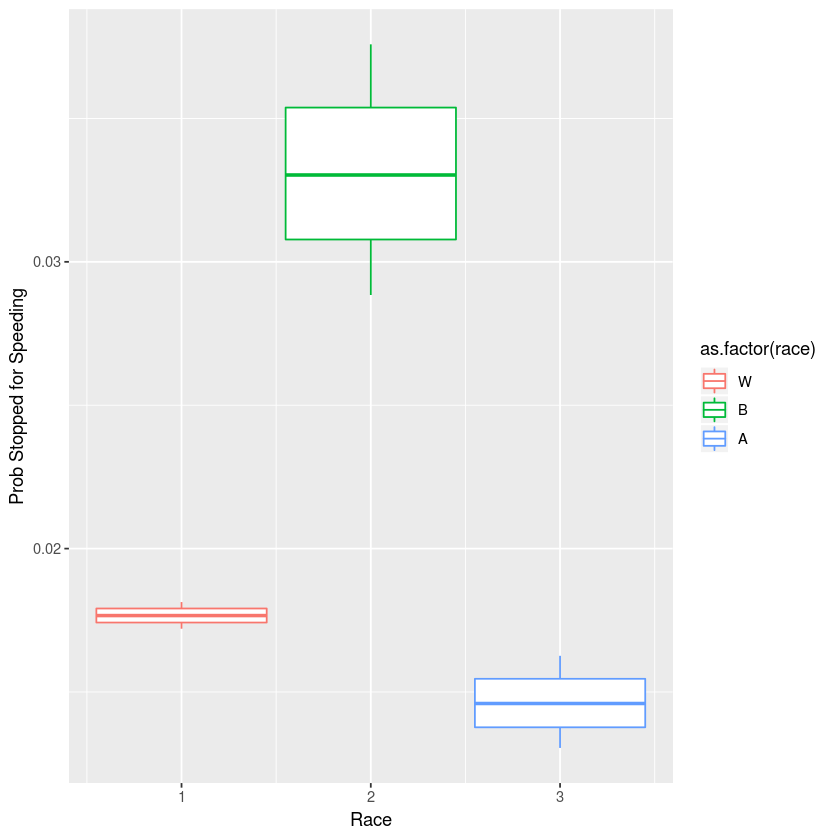

Using quantiles as value column: use value.var to override.


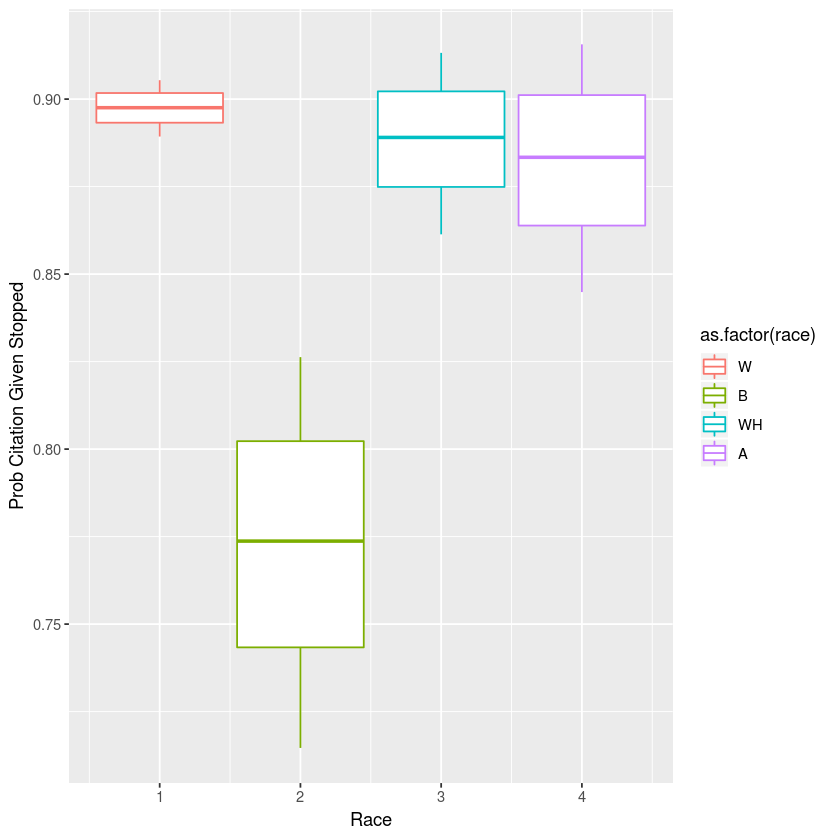

Using quantiles as value column: use value.var to override.


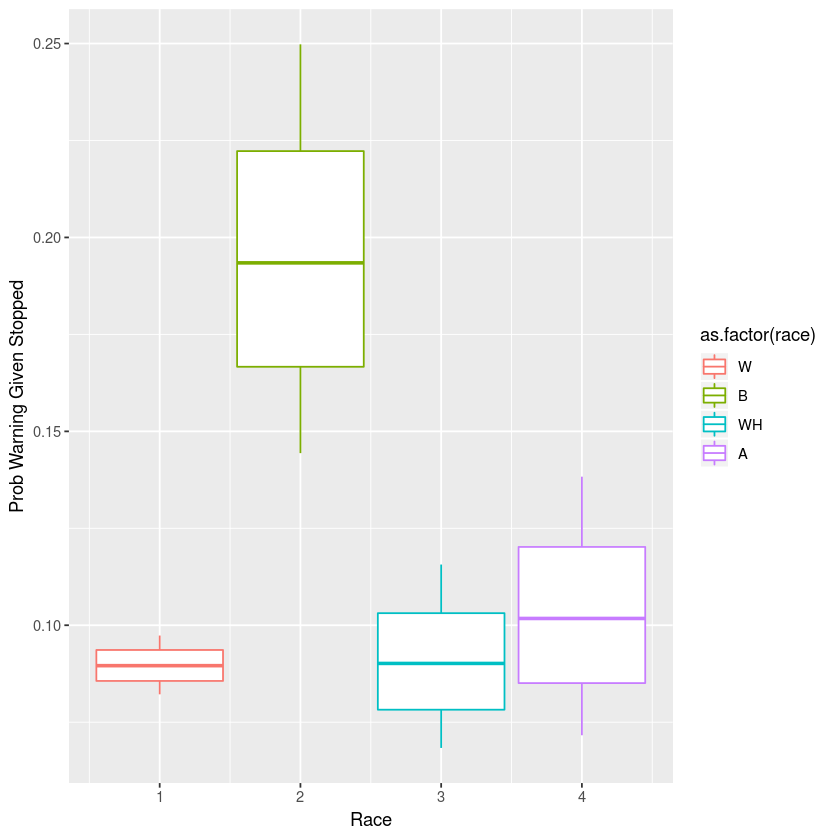

Using quantiles as value column: use value.var to override.


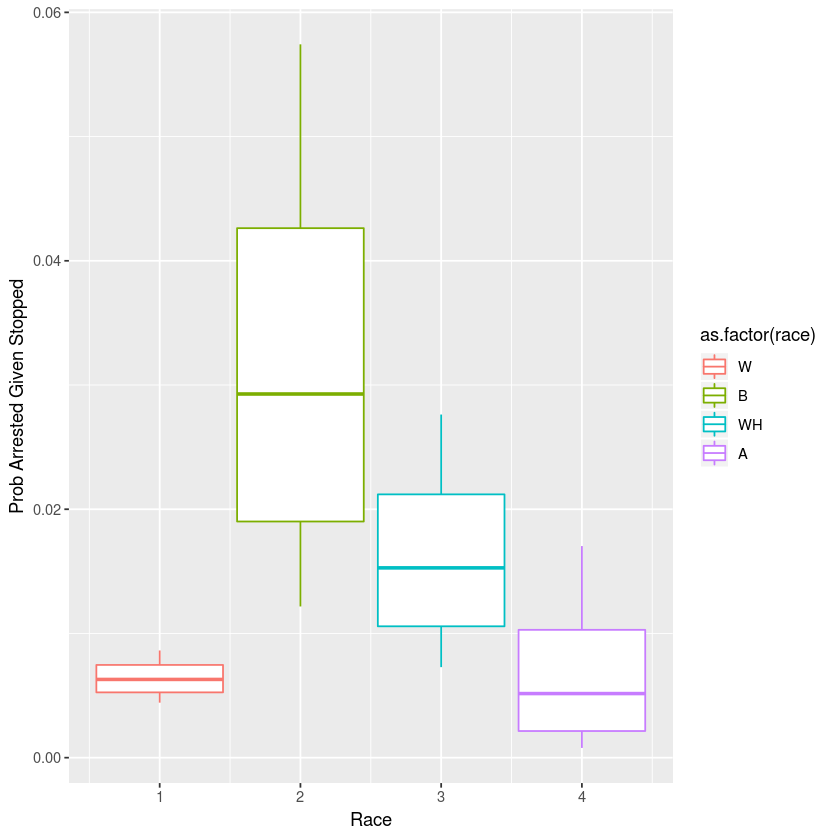

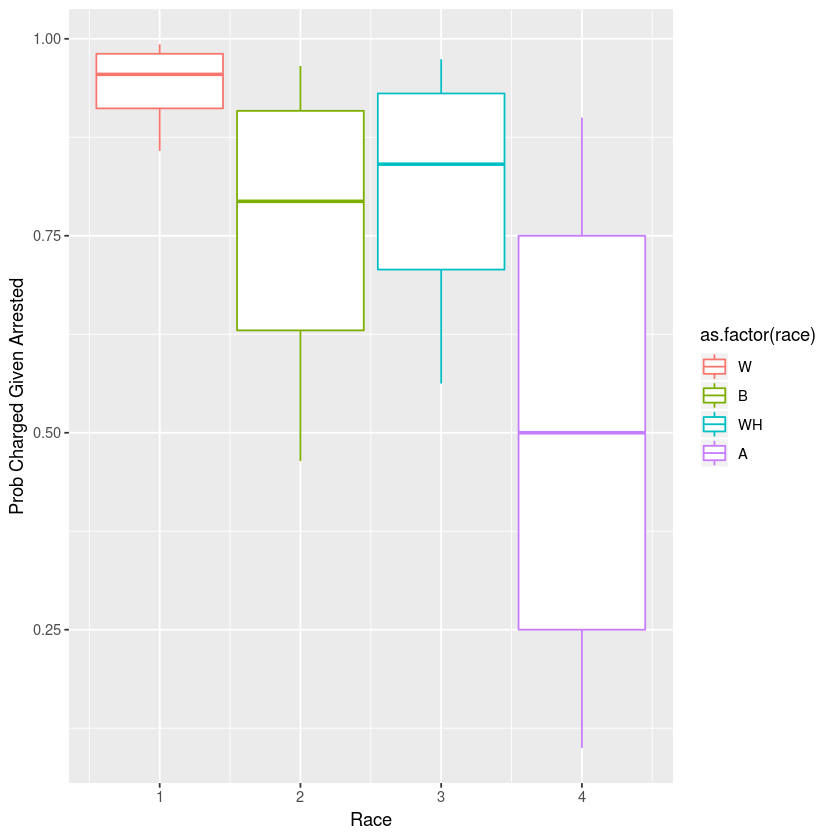

In [37]:
prob.speed.by.race = function(q,r){
        if (r == 'WH') { return(0.0) }
    
        n = stop.breakdown %>% filter(race==r) %>% 
        select('Pop Total') %>% unlist %>% as.numeric
    
        stopped = dat %>% filter(raceethn==r) %>% select(rpt2.traffic.speeding) %>% unlist %>% sum
    
        a = 1 + stopped
        b = 1 + n - stopped

        return( qbeta(q,a,b) )    
}

prob.cite.given.speeding = function(x,r){ dat %>%
                                          filter(raceethn==r & rpt2.traffic.speeding==1) %>%
                                          select(rpt6.citation) %>%
                                          as.matrix %>%
                                          binom.posterior(x,.) %>%
                                          return }

prob.warning.given.speeding = function(x,r){ dat %>%
                                          filter(raceethn==r & rpt2.traffic.speeding==1) %>%
                                          select(rpt6.warning) %>%
                                          as.matrix %>%
                                          binom.posterior(x,.) %>%
                                          return }

prob.arrest.given.speeding = function(x,r){ dat %>%
                                          filter(raceethn==r & rpt2.traffic.speeding==1) %>%
                                          select(rpt6.arrest) %>%
                                          as.matrix %>%
                                          binom.posterior(x,.) %>%
                                          return }

prob.charged.given.arrest.speeding = function(x,r){ dat %>%
                                              filter(raceethn==r & rpt2.traffic.speeding==1 & rpt6.arrest==1) %>%
                                              select(rpt7.not.charged) %>%
                                              as.matrix %>% `!` %>%
                                              binom.posterior(x,.) %>%
                                               return }

plot.posterior(prob.speed.by.race) + ylab('Prob Stopped for Speeding')
plot.posterior(prob.cite.given.speeding) + ylab('Prob Citation Given Stopped')
plot.posterior(prob.warning.given.speeding) + ylab('Prob Warning Given Stopped')
plot.posterior(prob.arrest.given.speeding) + ylab('Prob Arrested Given Stopped')
plot.posterior(prob.charged.given.arrest.speeding) + ylab('Prob Charged Given Arrested')

### Conclusion
This analysis is really just a first look at the ways that BPD may be treating its policed population unequally across race. Due to limitations of the dataset we were unable to answer questions regarding police activity towards the unhoused. We also were unable to fully assess the extent to which speeding stops resulted in disparate outcomes across racial groups.

Nevertheless, our findings suggest that discretionary stops exhibit a *strong* bias against black individuals. By every metric we looked at black individuals in Boulder are overpoliced. Our recommendations to the BPD include an immediate curtailment of discretionary stops coupled with a stringent internal investigation as to whether these biases are the result of a small set of officers or (more importantly) whether they reflect department-level policies.

To reiterate: this data is a record of hundreds of acts of state violence that occurred in 2018. We have the right against unreasonable search and seizure, and this dataset says that in 2018 BPD violated that right among black individuals who lived or traveled through our community. That we are allowing this to occur **in 2018** is nothing less than unacceptable and any delay in redressing it prolongs a serious injustice.